## Linear Non-Linear Functions



### Preface



Some modules we&rsquo;ll want:



In [1]:
import numpy as np
from numpy.linalg import norm
from scipy.stats import distributions as iid
import pandas as pd
import matplotlib.pyplot as plt

### Factories to generate basis functions



We can use a collection of functions as a *basis* with which to represent
an arbitrary function.



In [2]:
# Factory function for phi_k(x)
phi_factory = lambda c,s=1: lambda x: np.exp(-(1/(2*s))*norm(x-c)**2)  # RBF
# phi_factory = lambda c,s=1: lambda x: (x**c)/s  # Polynomial
# phi_factory = lambda c,s=1: lambda x: 1/(1+np.exp(c-x))  # logistic

# Also chose a domain over which we'll want to evaluate the unknown function
Domain = np.linspace(0,2*np.pi,100).tolist()

Now use  this factory to generate a set of $K$ basis functions for our
representation:



In [14]:
## Or
K=8

# Divide up domain
phis = {k:phi_factory(Domain[x]) for k,x in enumerate(range(1,len(Domain),len(Domain)//K))}

# Gram matrix
#phis = {k:phi_factory(X[k]) for k in range(K)}

phis[0] = lambda x: 1 # Constant function

Plot the basis functions:



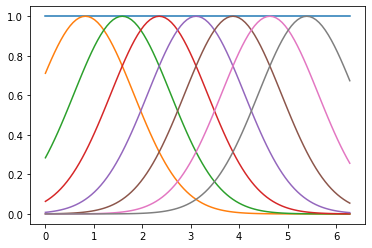

In [15]:
for k in range(K):
    plt.plot(Domain,[phis[k](x) for x in Domain])

### Data generating function



Let $f_0(X) = \mbox{E}(y|X)$ be an arbitrary function.  
After specifying this function we define a data data-generating
function for $(X,y)$ satisfying $y=f(X) + u$ and $\mbox{E}(u|X)$.



In [5]:
f0 = lambda x: x*np.sin(x) # True function; make up your own!

def dgp(N,sigma_u):
    X = iid.uniform(loc=0,scale=2*np.pi).rvs(N).tolist()
    X.sort()

    u = iid.norm(scale=sigma_u)

    y = pd.Series([f0(x) + u.rvs(1)[0] for x in X])

    return X,y

N = 20
X,y = dgp(N,1)

Consider scatterplot:



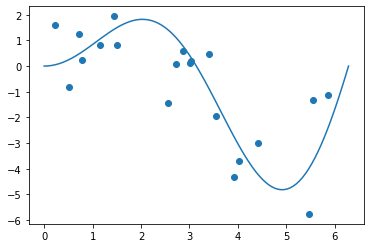

In [16]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.scatter(X,y)

ax.plot(Domain,[f0(x) for x in Domain])

### Estimation



Now regression.  Suppose we don&rsquo;t know the true function `f0`, and
can only estimate using observed data.



In [17]:
TX = {}
for k in phis.keys():
    TX[k] = [phis[k](x) for x in X]

TX = pd.DataFrame(TX)

try: # If y isn't a DataFrame make it one
    y = pd.DataFrame({'y':y})
except ValueError: # Guess it is!
    pass

alpha = pd.DataFrame(np.linalg.lstsq(TX, y,rcond=None)[0],index=TX.columns)

# Check fit:
e = y.squeeze() - (TX@alpha).squeeze()
e.var()

0.7793275309042805

Note that expected *within* sample error variance is effectively zero!

Now construct $\hat{f}$ and plot predictions:



In [18]:
def fhat(x,alpha):

    try: # Make alpha 1-d for calculations here
        alpha = alpha.squeeze()
    except AttributeError: # Maybe a list?
        pass
    
    yhat = 0
    for k,phik in phis.items():
        yhat += alpha[k]*phik(x)

    return yhat

Domain = np.linspace(0,2*np.pi,100).tolist()

Plot me!



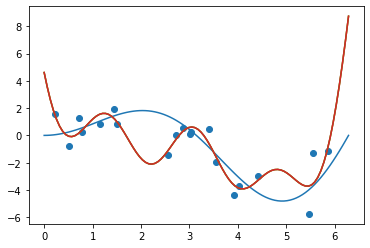

In [21]:
_ = ax.plot(Domain,[fhat(x,alpha) for x in Domain])
fig

### Evaluating Fit



We&rsquo;d like a measure of how well we&rsquo;ve done in estimating the
conditional expectation $f$.  First, compute the mean squared error
(MSE).  Note that when we don&rsquo;t know the true function `f_0` that this
is isn&rsquo;t feasible to compute.  Here we compute a sum of squared
prediction errors as a crude way of computing the integral $$ \int
(f_0(x) - \hat{f}(x))^2dx.  $$ This Riemann integral is appropriate
here because $x$ is uniformly distributed&#x2013;in general we want to
integrate with respect to $dF$.



In [10]:
dx = Domain[1]-Domain[0]
MSE = np.sum([((f0(x) - fhat(x,alpha))**2)*dx for x in Domain])

MSE

1488164574.3922582

Note that the disturbances $u$ don&rsquo;t
enter here&#x2014;this is the mean squared *approximation* error, not the
mean squared error of predictions of actual realizations of the data
$(y,X)$.  If we wanted the latter we&rsquo;d compute
$$
   \mbox{E}((y-\hat{f}(X))^2) =  \mbox{E}((y-f(X)-\epsilon)^2) =
\mbox{E}u^2 + \mbox{MSE}.
$$



#### Cross-validation error



We next estimate $f$ using the &ldquo;leave-one-out&rdquo; approach.



In [22]:
Yminus = []
Alpha = {}
for j in range(N):
    alphaminus = pd.DataFrame(np.linalg.lstsq(TX[TX.index!=j],
                                         y[TX.index!=j],rcond=None)[0],index=TX.columns)
    yminus = lambda x: fhat(x,alphaminus)
    Alpha[j]=alphaminus.squeeze()
    Yminus.append(yminus)

Alpha = pd.DataFrame(Alpha)

yhat = lambda x: np.array([yminus(x) for yminus in Yminus]).mean()

Take a look at $f$ and the leave-one-out estimator:



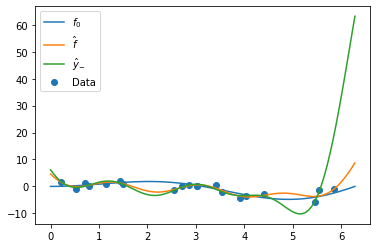

In [23]:
fig, ax = plt.subplots()

ax.scatter(X,y,label='Data')

ax.plot(Domain,[f0(x) for x in Domain],label='$f_0$')

ax.plot(Domain,[fhat(x,alpha) for x in Domain],label='$\hat{f}$')

ax.plot(Domain,[yhat(x) for x in Domain],label='$\hat{y}_{-}$')
ax.legend()

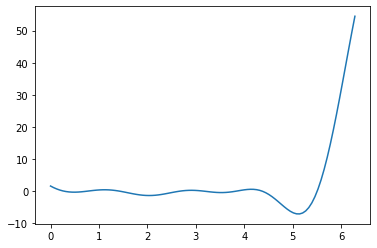

In [24]:
fig, ax = plt.subplots()

ax.plot(Domain,[yhat(x) - fhat(x,alpha) for x in Domain],label='$\hat{y}(x) - \hat{f}(x)$')